In [1]:
%%time
%reset -f

import pandas as pd
from rdkit.Chem import AllChem, Draw, Descriptors   
from rdkit import Chem, DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem import rdMolDescriptors
from rdkit.DataStructs import ExplicitBitVect

curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "N#Cc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

molecule_names = ['2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-14-Moore', 'AD-16-DMF', 'AD-18', 'AD-24', 'AD-25', 'AD-3', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-9', 'YD-30']
homo_lumo_gap = [3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 2.811, 3.231, 2.735, 2.878, 2.686, 3.215, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 3.137, 2.525]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame of Curcumin
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)

def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception:
        return None
    return None

# apply morgan fingerprint to the curcumin_df dataframe
curcumin_df['Morgan_Fingerprints'] = curcumin_df['Smiles'].apply(generate_morgan_fingerprint_safe)
curcumin_df = curcumin_df[curcumin_df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
morgan_df = pd.DataFrame(curcumin_df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

curcumin_df_mf = pd.concat([curcumin_df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)

# Convert any fingerprint to a bit vector
def convert_to_bit_vector(fp, nBits=2048):
    bit_vector = ExplicitBitVect(nBits)
    for bit in fp.GetNonzeroElements().keys():
        bit_vector.SetBit(bit % nBits)
    return bit_vector

# Atom pair Fingerprint bit vector conversion
def generate_atom_pair_fingerprint(mol, nBits=2048):
    fp = rdMolDescriptors.GetAtomPairFingerprint(mol)
    return convert_to_bit_vector(fp, nBits)

# Function to generate fingerprints
def generate_fingerprint(mol, fp_type, radius=2, n_bits=2048):
    if fp_type == 'morgan':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, useChirality=True)
    elif fp_type == 'fcfp':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=n_bits, useChirality=True)
    elif fp_type == 'atom_pair':
        return generate_atom_pair_fingerprint(mol, nBits=n_bits)

# Similarity functions
def calculate_similarity(fp1, fp2, metric):
    if metric == 'tanimoto':
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    elif metric == 'dice':
        return DataStructs.DiceSimilarity(fp1, fp2)
    elif metric == 'cosine':
        return DataStructs.CosineSimilarity(fp1, fp2)
    elif metric == 'kulczynski':
        return DataStructs.KulczynskiSimilarity(fp1, fp2)

curcumin_similarity_variants = {
    "seg01" : "Cc2ccc(/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1)cc2",
    "seg02" : "C/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1",
    "seg03" : "C/C=C/C(=O)CC(=O)/C=C/C",
    "seg04" : "Cc1ccc(/C=C/C=O)cc1",
    "seg05" : "C/C=C/C=O",
    "seg06" : "C/C=C/C1=CC(/C=C/C)=[O+][B-](F)(F)O1",
}

# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=['index', 'inchikey',  'HOMO_calc', 'LUMO_calc', 'LUMO_calib',
       'LUMO_calib_stds', 'HOMO_calib', 'HOMO_calib_stds', 'molW',
       'PCE_calc', 'Voc_calc', 'Jsc_calc', 'FF_calc', 'EQE_calc',
       'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib', 'EQE_calib',
       'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df["mol"] = opv_df["smiles"].apply(Chem.MolFromSmiles)

# Dictionary to hold the dataframes
similarity_dfs = {}

# Fingerprints and similarity methods
fingerprints = ['morgan', 'atom_pair']
similarities = ['tanimoto', 'cosine', 'kulczynski', 'dice']

# Loop over curcumin segments, fingerprints, and similarities
for key, smiles in curcumin_similarity_variants.items():
    specific_mol = Chem.MolFromSmiles(smiles)
    
    for fp_type in fingerprints:
        specific_fp = generate_fingerprint(specific_mol, fp_type)
        
        for sim_metric in similarities:
            opv_df_sim_segment = opv_df.copy()
            opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment['mol'].apply(lambda x: calculate_similarity(generate_fingerprint(x, fp_type), specific_fp, sim_metric))
            
            # Filter top 48% similar molecules
            quantile_value = opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'].quantile(0.52)
            opv_df_sim_segment = opv_df_sim_segment[opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] >= quantile_value]
            
            # Keep only the relevant columns (initial columns + similarity)
            opv_df_sim_segment = opv_df_sim_segment[['smiles', 'mol', 'GAP_calib', f'similarity_{key}_{fp_type}_{sim_metric}']]
            
            # Store the filtered dataframe in the dictionary
            similarity_dfs[f'{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment

            print(f"Generated dataframe for segment {key}, fingerprint {fp_type}, similarity {sim_metric}: shape {opv_df_sim_segment.shape}")

Generated dataframe for segment seg01, fingerprint morgan, similarity tanimoto: shape (24756, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity cosine: shape (24990, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity kulczynski: shape (24706, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity dice: shape (24756, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity tanimoto: shape (24639, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity cosine: shape (24661, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity kulczynski: shape (24621, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity dice: shape (24639, 4)
Generated dataframe for segment seg02, fingerprint morgan, similarity tanimoto: shape (24711, 4)
Generated dataframe for segment seg02, fingerprint morgan, similarity cosine: shape (24620, 4)
Generated dataframe for segm

In [2]:
%%time
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors

# Function to generate Morgan fingerprints safely
def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception as e:
        print(f"Error generating Morgan fingerprint for SMILES {smiles}: {e}")
        return None
    return None

# Dictionary to store processed dataframes
processed_similarity_dfs = {}

# Process each dataframe
for combination, df in similarity_dfs.items():
    print(f"Processing {combination}...")
    df = df.copy()
    
    # Generate Morgan fingerprints
    df['Morgan_Fingerprints'] = df['smiles'].apply(generate_morgan_fingerprint_safe)
    df = df[df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
    
    # Convert Morgan fingerprints to a DataFrame and concatenate with the original
    morgan_df = pd.DataFrame(df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

    df_combined = pd.concat([df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)
    
    # Store the combined DataFrame
    processed_similarity_dfs[combination] = df_combined
    print(f"Finished processing {combination} - shape {df_combined.shape}")

# Unpacking the dictionary to individual DataFrames
for combination, df in processed_similarity_dfs.items():
    globals()[f'similarity_dfs_{combination}'] = df

Processing seg01_morgan_tanimoto...
Finished processing seg01_morgan_tanimoto - shape (24756, 2052)
Processing seg01_morgan_cosine...
Finished processing seg01_morgan_cosine - shape (24990, 2052)
Processing seg01_morgan_kulczynski...
Finished processing seg01_morgan_kulczynski - shape (24706, 2052)
Processing seg01_morgan_dice...
Finished processing seg01_morgan_dice - shape (24756, 2052)
Processing seg01_atom_pair_tanimoto...
Finished processing seg01_atom_pair_tanimoto - shape (24639, 2052)
Processing seg01_atom_pair_cosine...
Finished processing seg01_atom_pair_cosine - shape (24661, 2052)
Processing seg01_atom_pair_kulczynski...
Finished processing seg01_atom_pair_kulczynski - shape (24621, 2052)
Processing seg01_atom_pair_dice...
Finished processing seg01_atom_pair_dice - shape (24639, 2052)
Processing seg02_morgan_tanimoto...
Finished processing seg02_morgan_tanimoto - shape (24711, 2052)
Processing seg02_morgan_cosine...
Finished processing seg02_morgan_cosine - shape (24620, 20

In [3]:
processed_similarity_dfs.keys()

dict_keys(['seg01_morgan_tanimoto', 'seg01_morgan_cosine', 'seg01_morgan_kulczynski', 'seg01_morgan_dice', 'seg01_atom_pair_tanimoto', 'seg01_atom_pair_cosine', 'seg01_atom_pair_kulczynski', 'seg01_atom_pair_dice', 'seg02_morgan_tanimoto', 'seg02_morgan_cosine', 'seg02_morgan_kulczynski', 'seg02_morgan_dice', 'seg02_atom_pair_tanimoto', 'seg02_atom_pair_cosine', 'seg02_atom_pair_kulczynski', 'seg02_atom_pair_dice', 'seg03_morgan_tanimoto', 'seg03_morgan_cosine', 'seg03_morgan_kulczynski', 'seg03_morgan_dice', 'seg03_atom_pair_tanimoto', 'seg03_atom_pair_cosine', 'seg03_atom_pair_kulczynski', 'seg03_atom_pair_dice', 'seg04_morgan_tanimoto', 'seg04_morgan_cosine', 'seg04_morgan_kulczynski', 'seg04_morgan_dice', 'seg04_atom_pair_tanimoto', 'seg04_atom_pair_cosine', 'seg04_atom_pair_kulczynski', 'seg04_atom_pair_dice', 'seg05_morgan_tanimoto', 'seg05_morgan_cosine', 'seg05_morgan_kulczynski', 'seg05_morgan_dice', 'seg05_atom_pair_tanimoto', 'seg05_atom_pair_cosine', 'seg05_atom_pair_kulczy

In [7]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb
import math

# Mappings for segments, fingerprint types, and similarity methods
segment_map = {
    'seg01': 'Segment 01',
    'seg02': 'Segment 02',
    'seg03': 'Segment 03',
    'seg04': 'Segment 04',
    'seg05': 'Segment 05',
    "seg06" : "Segment 06",
}

fingerprint_map = {
    'morgan': 'Morgan Fingerprint',
    'atom_pair': 'Atom Pair Fingerprint'
}

similarity_map = {
    'tanimoto': 'Tanimoto Similarity',
    'cosine': 'Cosine Similarity',
    'kulczynski': 'Kulczynski Similarity',
    'dice': 'Dice Similarity'
}

# Initialize a list to store results
results = []

# Process each dataframe from the global namespace
for combination, df in processed_similarity_dfs.items():
    print(f"Processing {combination}...")
    
    # Extract features (X) and target (y)
    X = df.iloc[:, 4:]  # Assuming the first 4 columns are non-feature columns
    y = df['GAP_calib']  # Target variable
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
    
    # Initialize and train the LightGBM model
    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R^2 scores and RMSE
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = math.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Extracting segment, fingerprint type, and similarity method from the combination name
    parts = combination.split('_')  # Split the combination string into parts
    
    # Handle the case where the fingerprint type is 'atom_pair'
    if '_'.join(parts[1:3]) == 'atom_pair':
        segment_key = parts[0]  # Assuming the segment is the first part
        fingerprint_type_key = '_'.join(parts[1:3])  # Join parts to get 'atom_pair'
        similarity_method_key = parts[3]  # Similarity method is the fourth part
    else:
        segment_key = parts[0]  # Assuming the segment is the first part
        fingerprint_type_key = parts[1]  # Fingerprint type is the second part
        similarity_method_key = parts[2]  # Similarity method is the third part
    
    # Map the keys to human-readable names using the mappings
    segment_name = segment_map.get(segment_key, segment_key)
    fingerprint_name = fingerprint_map.get(fingerprint_type_key, fingerprint_type_key)
    similarity_name = similarity_map.get(similarity_method_key, similarity_method_key)
    
    # Store results in the list
    results.append({
        'Segment': segment_name,
        'Fingerprint Type': fingerprint_name,
        'Similarity Method': similarity_name,
        'Train R2 Score': train_r2,
        'Test R2 Score': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse
    })
    
    print(f"Done processing {combination} with Test R^2 score: {test_r2} and Test RMSE: {test_rmse}")

# Convert results to a DataFrame for further analysis
final_results = pd.DataFrame(results)

# Save the results to a CSV file for further use
final_results.to_csv(path_or_buf=r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\Phase03.csv")

# Display the first few rows of the results
final_results.head()

Processing seg01_morgan_tanimoto...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2342
[LightGBM] [Info] Number of data points in the train set: 11548, number of used features: 1171
[LightGBM] [Info] Start training from score 2.877134
Done processing seg01_morgan_tanimoto with Test R^2 score: 0.9170366372707716 and Test RMSE: 0.17167720872970774
Processing seg01_morgan_cosine...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Number of data points in the train set: 11586, number of used features: 1168
[LightGBM] [Info] Start training from score 2.824746
D

,Segment,Fingerprint Type,Similarity Method,Train R2 Score,Test R2 Score,Train RMSE,Test RMSE
0,Segment 01,Morgan Fingerprint,Tanimoto Similarity,0.995490,0.917037,0.041905,0.171677
1,Segment 01,Morgan Fingerprint,Cosine Similarity,0.995105,0.928905,0.042025,0.158311
2,Segment 01,Morgan Fingerprint,Kulczynski Similarity,0.994906,0.925638,0.041543,0.159406
3,Segment 01,Morgan Fingerprint,dice,0.995490,0.917037,0.041905,0.171677
4,Segment 01,Atom Pair Fingerprint,Tanimoto Similarity,0.996082,0.945269,0.035371,0.131461


In [8]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Load the results from the CSV file
final_results = pd.read_csv(r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\Phase03.csv")

# Calculate the absolute variance between Train and Test R² scores
final_results['Variance'] = abs(final_results['Train R2 Score'] - final_results['Test R2 Score'])

# Create six plots, one for each segment
for segment in final_results['Segment'].unique():
    # Filter data for the current segment
    segment_data = final_results[final_results['Segment'] == segment]
    
    # Identify the best model (highest Test R² score)
    best_model = segment_data.loc[segment_data['Test R2 Score'].idxmax()]
    
    # Create a grouped bar plot for Train and Test R² scores
    fig = go.Figure()
    
    # Add bars for Train R² scores
    fig.add_trace(go.Bar(
        x=segment_data['Fingerprint Type'] + ' - ' + segment_data['Similarity Method'],
        y=segment_data['Train R2 Score'],
        name='Train R² Score',
        marker_color='blue',
        text=segment_data['Train R2 Score'].round(4),
        textposition='auto'
    ))
    
    # Add bars for Test R² scores
    fig.add_trace(go.Bar(
        x=segment_data['Fingerprint Type'] + ' - ' + segment_data['Similarity Method'],
        y=segment_data['Test R2 Score'],
        name='Test R² Score',
        marker_color='orange',
        text=segment_data['Test R2 Score'].round(4),
        textposition='auto'
    ))
    
    # Add a line for the absolute variance (secondary y-axis)
    fig.add_trace(go.Scatter(
        x=segment_data['Fingerprint Type'] + ' - ' + segment_data['Similarity Method'],
        y=segment_data['Variance'],
        mode='lines+markers',
        name='Absolute Variance',
        yaxis='y2',
        line=dict(color='red', dash='dash')
    ))
    
    # Update layout to include secondary y-axis
    fig.update_layout(
        title=f'R² Scores and Variance for {segment}',
        xaxis_title='Fingerprint Type - Similarity Method',
        yaxis_title='R² Score',
        yaxis2=dict(
            title='Absolute Variance',
            overlaying='y',
            side='right',
            showgrid=False,
            zeroline=False
        ),
        barmode='group',
        legend=dict(x=0.85, y=1.0),
        width=1000,
        height=600
    )
    
    # Add annotation for the best model
    fig.add_annotation(
        x=best_model['Fingerprint Type'] + ' - ' + best_model['Similarity Method'],
        y=best_model['Test R2 Score'],
        text=f"Best Model:<br>Test R²={best_model['Test R2 Score']:.4f}<br>{best_model['Fingerprint Type']} - {best_model['Similarity Method']}",
        showarrow=True,
        arrowhead=3,
        ax=0,
        ay=-50,
        font=dict(color="black", size=12),
        bgcolor="silver"
    )

    # legend orientation
    fig.update_layout(
    legend=dict(
        orientation='h',  # Horizontal orientation
        yanchor='bottom',
        y=1.01,  # Position above the plot
        xanchor='center',
        x=0.5  # Center horizontally
    )
)
    
    # Show the plot
    fig.show()

In [9]:
import pandas as pd
import plotly.graph_objects as go

# Load the results from the CSV file
final_results = pd.read_csv(r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\Phase03.csv")

# Calculate the absolute variance between Train and Test R² scores
final_results['Variance'] = abs(final_results['Train R2 Score'] - final_results['Test R2 Score'])

# Initialize an empty DataFrame to store the best models from all segments
best_models_all_segments = pd.DataFrame()

# Process each segment to find the best model
for segment in final_results['Segment'].unique():
    # Filter data for the current segment
    segment_data = final_results[final_results['Segment'] == segment]
    
    # Identify the best model (highest Test R² score)
    best_model = segment_data.loc[segment_data['Test R2 Score'].idxmax()]
    
    # Append to the DataFrame of best models
    best_models_all_segments = best_models_all_segments.append(best_model, ignore_index=True)

# Create a grouped bar plot for Train and Test R² scores of the best models
fig = go.Figure()

# Add bars for Train R² scores
fig.add_trace(go.Bar(
    x=best_models_all_segments['Segment'] + ' - ' + best_models_all_segments['Fingerprint Type'] + ' - ' + best_models_all_segments['Similarity Method'],
    y=best_models_all_segments['Train R2 Score'],
    name='Train R² Score',
    marker_color='blue',
    text=best_models_all_segments['Train R2 Score'].round(4),
    textposition='auto'
))

# Add bars for Test R² scores
fig.add_trace(go.Bar(
    x=best_models_all_segments['Segment'] + ' - ' + best_models_all_segments['Fingerprint Type'] + ' - ' + best_models_all_segments['Similarity Method'],
    y=best_models_all_segments['Test R2 Score'],
    name='Test R² Score',
    marker_color='orange',
    text=best_models_all_segments['Test R2 Score'].round(4),
    textposition='auto'
))

# Add a line for the absolute variance (secondary y-axis)
fig.add_trace(go.Scatter(
    x=best_models_all_segments['Segment'] + ' - ' + best_models_all_segments['Fingerprint Type'] + ' - ' + best_models_all_segments['Similarity Method'],
    y=best_models_all_segments['Variance'],
    mode='lines+markers',
    name='Absolute Variance',
    yaxis='y2',
    line=dict(color='red', dash='dash')
))

# Update layout to include secondary y-axis
fig.update_layout(
    title='Best Models Across All Segments',
    xaxis_title='Model',
    yaxis_title='R² Score',
    yaxis2=dict(
        title='Absolute Variance',
        overlaying='y',
        side='right',
        showgrid=False,
        zeroline=False
    ),
    barmode='group',
    legend=dict(x=0.85, y=1.0),
    width=1000,
    height=600
)

# Add annotation for the best model
# Note: For a single annotation, you may need to specify manually or use another method to highlight specific points.

# legend orientation
fig.update_layout(
    legend=dict(
        orientation='h',  # Horizontal orientation
        yanchor='bottom',
        y=1.01,  # Position above the plot
        xanchor='center',
        x=0.5  # Center horizontally
    )
)

# Show the plot
fig.show()

C:\Users\Chamod Peiris\AppData\Local\Temp\ipykernel_5248\2427960453.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 18479, number of used features: 1243
[LightGBM] [Info] Start training from score 2.676840


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


___________________________________________________________________
Model similarity_dfs_seg01_atom_pair_tanimoto
MAE Value: 0.09120 & RMSE Value: 0.13028
Prediction --> model MAE: 0.17322 & RMSE: 0.04001
___________________________________________________________________


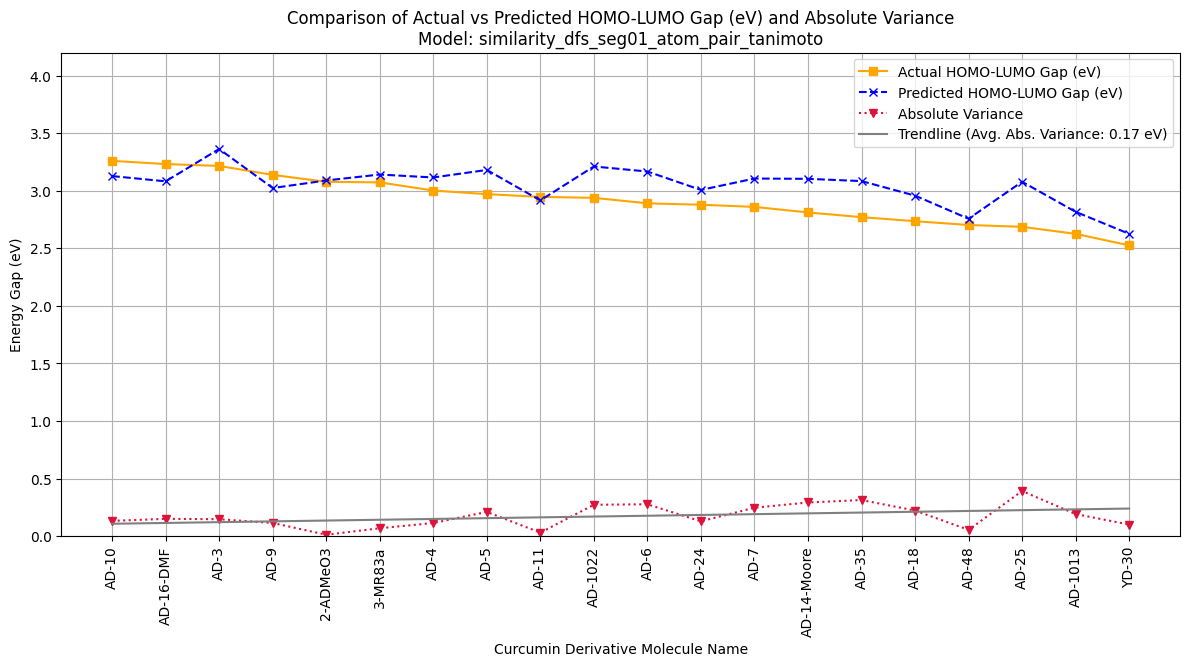

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2466
[LightGBM] [Info] Number of data points in the train set: 18646, number of used features: 1233
[LightGBM] [Info] Start training from score 2.678737


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


___________________________________________________________________
Model similarity_dfs_seg02_atom_pair_kulczynski
MAE Value: 0.09241 & RMSE Value: 0.13311
Prediction --> model MAE: 0.13433 & RMSE: 0.03585
___________________________________________________________________


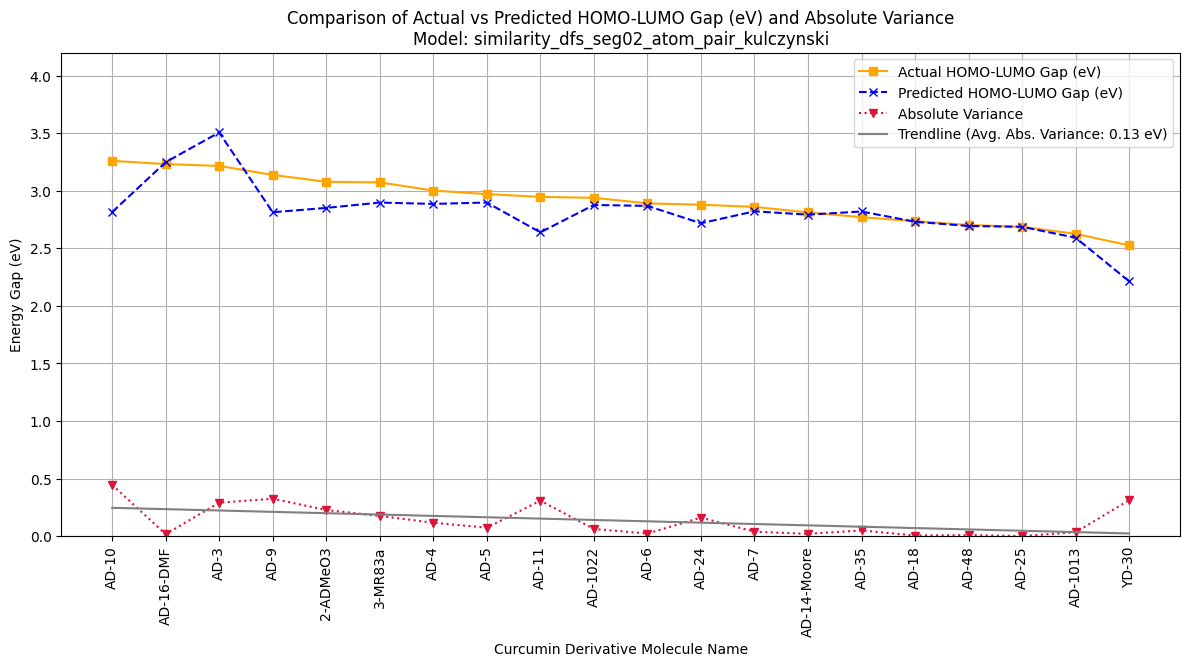

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2462
[LightGBM] [Info] Number of data points in the train set: 18508, number of used features: 1231
[LightGBM] [Info] Start training from score 2.688094
___________________________________________________________________
Model similarity_dfs_seg03_atom_pair_cosine
MAE Value: 0.09185 & RMSE Value: 0.13195
Prediction --> model MAE: 0.24374 & RMSE: 0.07628
___________________________________________________________________


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


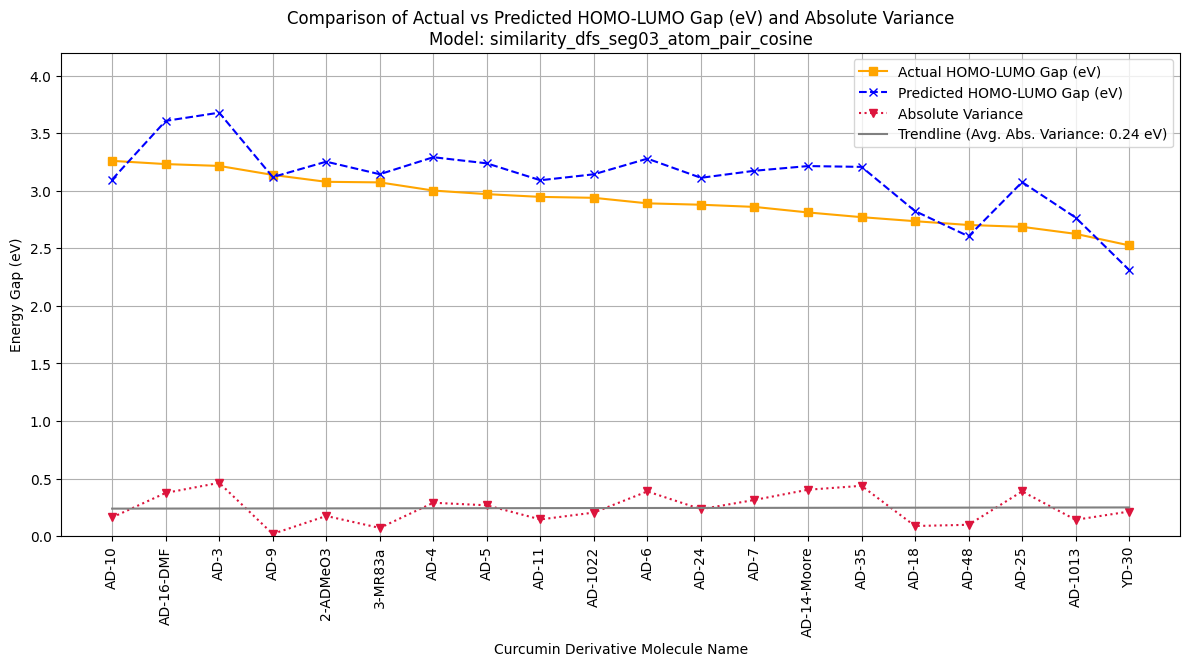

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2442
[LightGBM] [Info] Number of data points in the train set: 18544, number of used features: 1221
[LightGBM] [Info] Start training from score 2.678859
___________________________________________________________________
Model similarity_dfs_seg04_atom_pair_cosine
MAE Value: 0.08973 & RMSE Value: 0.12787
Prediction --> model MAE: 0.18475 & RMSE: 0.05459
___________________________________________________________________


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


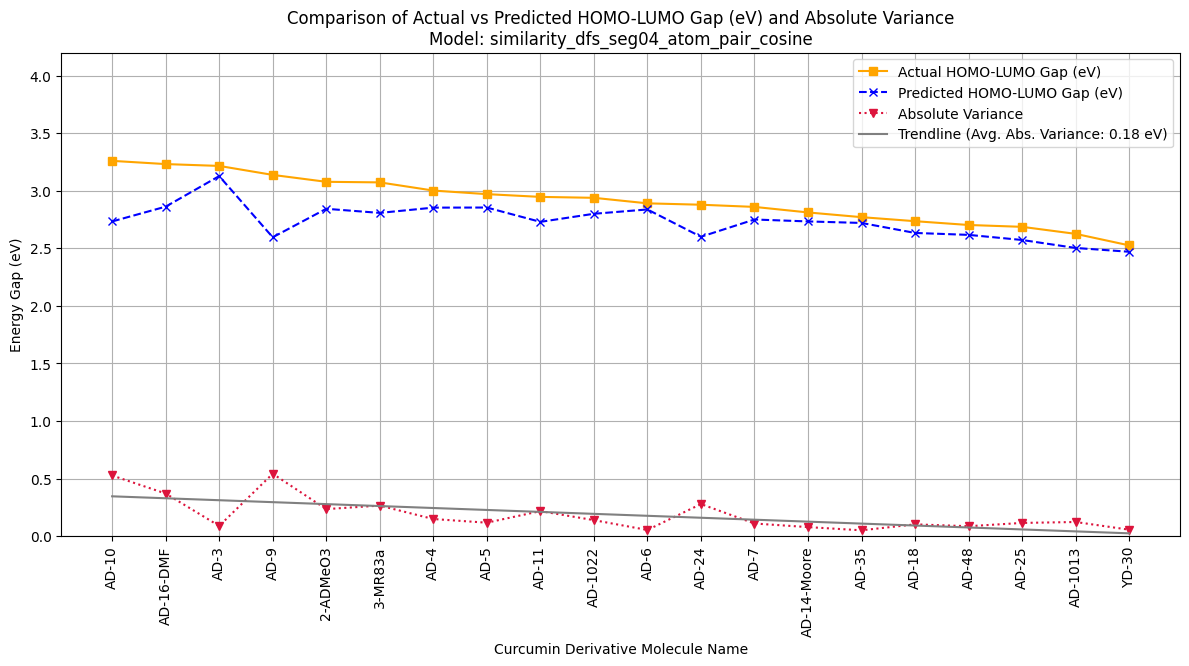

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2420
[LightGBM] [Info] Number of data points in the train set: 18509, number of used features: 1210
[LightGBM] [Info] Start training from score 2.663324
___________________________________________________________________
Model similarity_dfs_seg05_atom_pair_cosine
MAE Value: 0.08943 & RMSE Value: 0.12890
Prediction --> model MAE: 0.13461 & RMSE: 0.04157
___________________________________________________________________


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


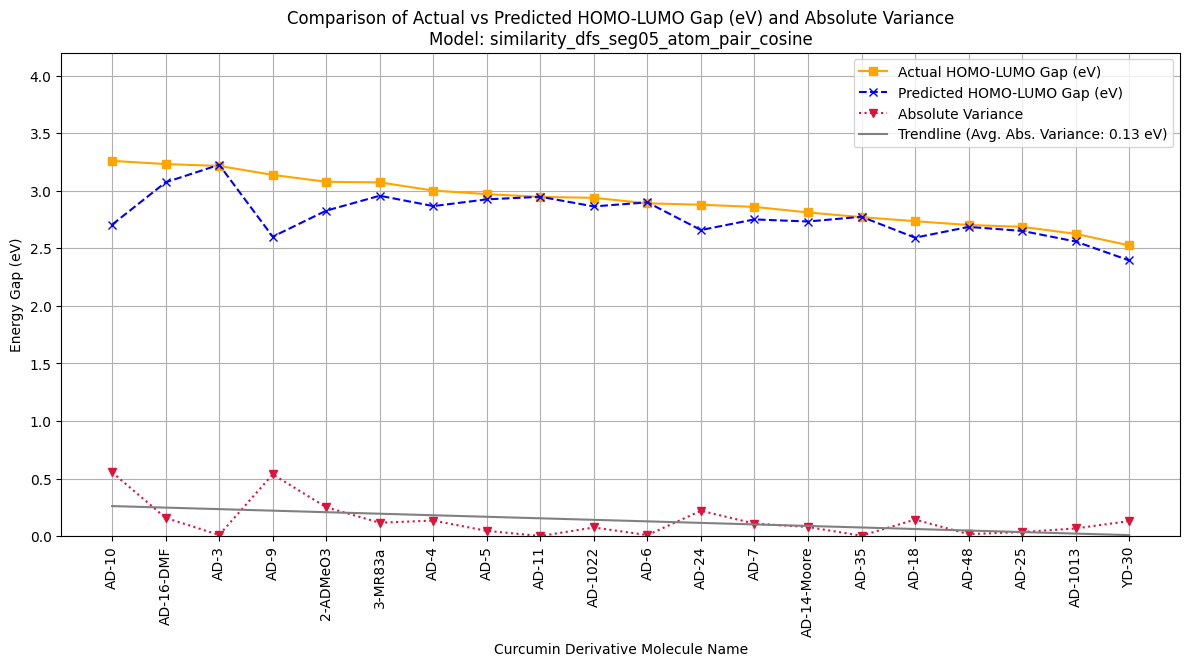

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 18477, number of used features: 1228
[LightGBM] [Info] Start training from score 2.674721
___________________________________________________________________
Model similarity_dfs_seg06_atom_pair_cosine
MAE Value: 0.09024 & RMSE Value: 0.13074
Prediction --> model MAE: 0.25317 & RMSE: 0.09904
___________________________________________________________________


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


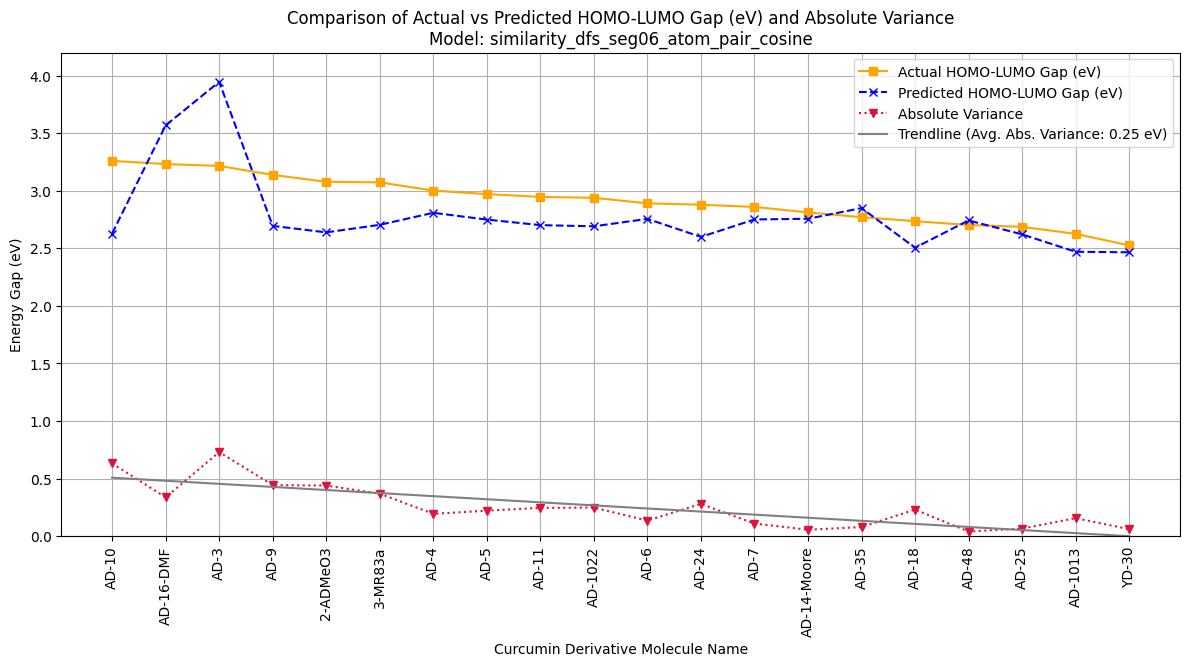

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# List of the best model dataframes
best_models_all_segments = ["similarity_dfs_seg01_atom_pair_tanimoto",
                            "similarity_dfs_seg02_atom_pair_kulczynski", 
                            "similarity_dfs_seg03_atom_pair_cosine", 
                            "similarity_dfs_seg04_atom_pair_cosine", 
                            "similarity_dfs_seg05_atom_pair_cosine",
                            "similarity_dfs_seg06_atom_pair_cosine"]

# Iterate through the list of best models
for model_name in best_models_all_segments:
    # Dynamically reference the corresponding dataframe
    model_df = globals()[model_name]
    
    x = model_df.iloc[:, 4:]
    y = model_df['GAP_calib']
    
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)
    
    # Initialize and train the LightGBM model
    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)
    model.fit(x_train, y_train)
    
    # Make predictions and calculate R^2 score
    y_pred = model.predict(x_test)
    
    # Calculate MAE Value and RMSE for the model
    mae_model = mean_absolute_error(y_test, y_pred)
    rmse_model = mean_squared_error(y_test, y_pred, squared=False)
    
    curcumin_df_mf_pred = curcumin_df_mf.copy()
    curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 5:])
    
    r2_predict = mean_absolute_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
    rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
    
    print("___________________________________________________________________")
    print(f"Model {model_name}")
    print(f"MAE Value: {mae_model:.5f} & RMSE Value: {rmse_model:.5f}")
    print(f"Prediction --> model MAE: {r2_predict:.5f} & RMSE: {rmse_predict:.5f}")   
    print("___________________________________________________________________")
    
    # Sort curcumin_df_mf_pred by 'Homo-Lumo Gap (eV)' in descending order and reset the index
    curcumin_df_mf_pred = curcumin_df_mf_pred.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)
    
    # Calculate the absolute variance between 'Homo-Lumo Gap (eV)' and 'Homo-Lumo Gap (eV) Pred'
    curcumin_df_mf_pred['absolute_variance'] = (curcumin_df_mf_pred['Homo-Lumo Gap (eV)'] - curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred']).abs()
    
    # Save DF
    curcumin_df_mf_pred.to_csv(path_or_buf=(f"C:/Users/Chamod Peiris/Documents/Curcumin_Scripts/curcumin_pred_48_{model_name}.csv"))

    # Calculate linear trendline for absolute variance
    x_vals = curcumin_df_mf_pred.index
    y_vals = curcumin_df_mf_pred['absolute_variance']
    coefficients = np.polyfit(x_vals, y_vals, 1)  # Fit a linear polynomial
    trendline = np.polyval(coefficients, x_vals)
    
    # Calculate the average absolute variance
    average_variance = y_vals.mean()
    
    # Plotting the actual vs predicted energy gaps
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot the actual values
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='s', label='Actual HOMO-LUMO Gap (eV)', color='orange')
    
    # Plot the predicted values
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'], marker='x', linestyle='--', label='Predicted HOMO-LUMO Gap (eV)', color='blue')
    
    # Plot the absolute variance as a dotted line
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['absolute_variance'], marker='v', linestyle=':', label='Absolute Variance', color='crimson')
    
    # Plot the trendline for absolute variance
    ax1.plot(curcumin_df_mf_pred['Molecule'], trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')
    
    # Set labels for the axes and the range
    ax1.set_xlabel('Curcumin Derivative Molecule Name')
    ax1.set_ylabel('Energy Gap (eV)')
    ax1.set_ylim([0, 4.2])  # Adjust the y-axis range as needed
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper right')
    
    # Customize the plot
    plt.title(f'Comparison of Actual vs Predicted HOMO-LUMO Gap (eV) and Absolute Variance\nModel: {model_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=90)
    
    # Show the plot
    plt.show()

In [10]:
data = pd.read_excel(r"C:\Users\Chamod Peiris\OneDrive - Chulalongkorn University\MS_Projects\Cheminformatics\Curcumin_EnergyGap\Curcumin_Masked_Data_Training_FInal.xlsx")
data.columns

Index(['Molecule', 'Molecular Weight', 'LogP', 'Homo-Lumo Gap (eV)', 'Smiles',
       'curcumin_pred_init_best', 'curcumin_pred_init_best_opt',
       'curcumin_pred_48_best_opt', 'curcumin_pred_48_20mol_pred_bes',
       'curcumin_pred_48_seg02_ similarity_dfs',
       'curcumin_pred_48_seg05_ similarity_dfs'],
      dtype='object')

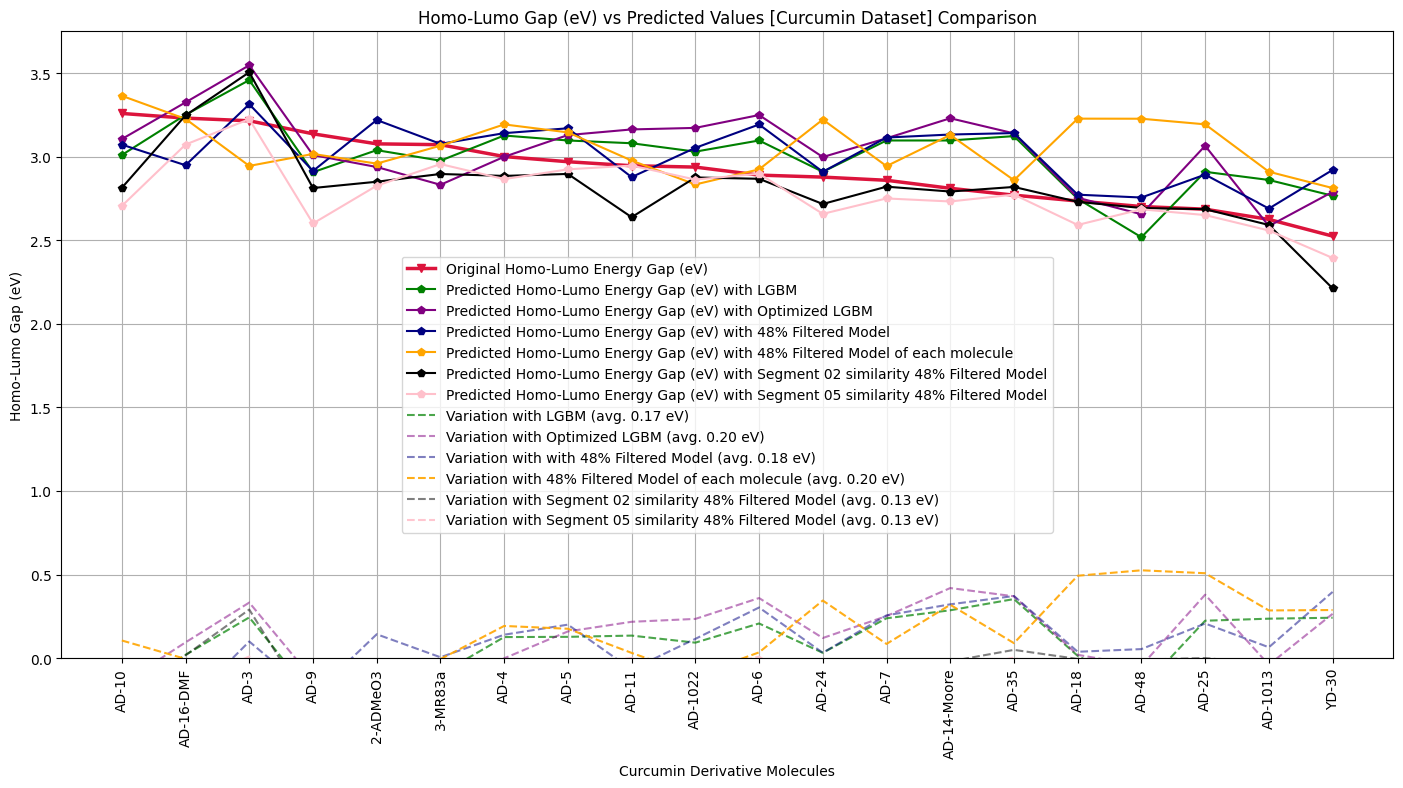

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `data` is your DataFrame and contains the necessary columns

# Calculate the variations
variation_lgbm = data['curcumin_pred_init_best'] - data['Homo-Lumo Gap (eV)']
variation_optimized_lgbm = data['curcumin_pred_init_best_opt'] - data['Homo-Lumo Gap (eV)']
variation_48percent = data['curcumin_pred_48_best_opt'] - data['Homo-Lumo Gap (eV)']
variation_48percent_each_mol = data['curcumin_pred_48_20mol_pred_bes'] - data['Homo-Lumo Gap (eV)']
variation_48percent_Seg02_Similarity = data['curcumin_pred_48_seg02_ similarity_dfs'] - data['Homo-Lumo Gap (eV)']
variation_48percent_Seg05_Similarity = data['curcumin_pred_48_seg05_ similarity_dfs'] - data['Homo-Lumo Gap (eV)']

# Calculate the average variations
avg_variation_lgbm = np.mean(np.abs(variation_lgbm))
avg_variation_optimized_lgbm = np.mean(np.abs(variation_optimized_lgbm))
avg_variation_48percent = np.mean(np.abs(variation_48percent))
avg_variation_48percent_each_mol = np.mean(np.abs(variation_48percent_each_mol))
avg_variation_48percent_Seg02_Similarity = np.mean(np.abs(variation_48percent_Seg02_Similarity))
avg_variation_48percent_Seg05_Similarity = np.mean(np.abs(variation_48percent_Seg05_Similarity))

# Plotting the original GAP and the predicted values from both models
plt.figure(figsize=(14, 7))

# Plot original Homo-Lumo Gap (eV)
plt.plot(data['Molecule'], data['Homo-Lumo Gap (eV)'], marker='v', label='Original Homo-Lumo Energy Gap (eV)', color="crimson", linewidth = 2.5)

# Plot predicted Homo-Lumo Gap (eV) using curcumin_pred_init_best
plt.plot(data['Molecule'], data['curcumin_pred_init_best'], marker='p', label='Predicted Homo-Lumo Energy Gap (eV) with LGBM', color="green")

# Plot predicted Homo-Lumo Gap (eV) using curcumin_pred_init_best_opt
plt.plot(data['Molecule'], data['curcumin_pred_init_best_opt'], marker='p', label='Predicted Homo-Lumo Energy Gap (eV) with Optimized LGBM', color="purple")

#Plot predicted Homo-Lumo Gap (eV) using curcumin_pred_48_best_opt
plt.plot(data['Molecule'], data['curcumin_pred_48_best_opt'], marker='p', label=f'Predicted Homo-Lumo Energy Gap (eV) with 48% Filtered Model', color="navy")

#Plot predicted Homo-Lumo Gap (eV) using curcumin_pred_48_20mol_pred_bes
plt.plot(data['Molecule'], data['curcumin_pred_48_20mol_pred_bes'], marker='p', label=f'Predicted Homo-Lumo Energy Gap (eV) with 48% Filtered Model of each molecule', color="orange")

#Plot predicted Homo-Lumo Gap (eV) using curcumin_pred_48_Seg02_best
plt.plot(data['Molecule'], data['curcumin_pred_48_seg02_ similarity_dfs'], marker='p', label=f'Predicted Homo-Lumo Energy Gap (eV) with Segment 02 similarity 48% Filtered Model', color="black")

#Plot predicted Homo-Lumo Gap (eV) using curcumin_pred_48_Seg05_Best
plt.plot(data['Molecule'], data['curcumin_pred_48_seg05_ similarity_dfs'], marker='p', label=f'Predicted Homo-Lumo Energy Gap (eV) with Segment 05 similarity 48% Filtered Model', color="pink")

# Plot variation lines
plt.plot(data['Molecule'], variation_lgbm, linestyle='--', color='green', alpha=0.7, label=f'Variation with LGBM (avg. {avg_variation_lgbm:.2f} eV)')
plt.plot(data['Molecule'], variation_optimized_lgbm, linestyle='--', color='purple', alpha=0.5, label=f'Variation with Optimized LGBM (avg. {avg_variation_optimized_lgbm:.2f} eV)')
plt.plot(data['Molecule'], variation_48percent, linestyle='--', color='navy', alpha=0.5, label=f'Variation with with 48% Filtered Model (avg. {avg_variation_48percent:.2f} eV)')
plt.plot(data['Molecule'], variation_48percent_each_mol, linestyle='--', color='orange', alpha=0.9, label=f'Variation with 48% Filtered Model of each molecule (avg. {avg_variation_48percent_each_mol:.2f} eV)')
plt.plot(data['Molecule'], variation_48percent_Seg02_Similarity, linestyle='--', color='black', alpha=0.5, label=f'Variation with Segment 02 similarity 48% Filtered Model (avg. {avg_variation_48percent_Seg02_Similarity:.2f} eV)')
plt.plot(data['Molecule'], variation_48percent_Seg05_Similarity, linestyle='--', color='pink', alpha=0.9, label=f'Variation with Segment 05 similarity 48% Filtered Model (avg. {avg_variation_48percent_Seg05_Similarity:.2f} eV)')

# Labeling the axes
plt.xlabel('Curcumin Derivative Molecules')
plt.ylabel('Homo-Lumo Gap (eV)')

# Adding grid, layout, and title
plt.grid(True)
plt.tight_layout()
plt.title('Homo-Lumo Gap (eV) vs Predicted Values [Curcumin Dataset] Comparison')

# Displaying legend with centered position
plt.legend(loc='center',bbox_to_anchor=(0.5, 0.42))

# Setting y-axis limits
plt.ylim(0, 3.75)

# Rotating x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

In [55]:
import plotly.graph_objects as go

model_names = [
    "E Gap - LGBM",
    "E Gap - Optimized LGBM",
    "E Gap - 48% Filtered Model",
    "E Gap - 48% Filtered Model of each molecule",
    "E Gap - Segment 02 similarity 48% Filtered Model",
    "E Gap - Segment 05 similarity 48% Filtered Model"
]

rmse_values = [
    0.19350,
    0.23459,
    0.20968,
    0.20961,
    0.13433,
    0.13461
]

mae_values = [
    0.168478,
    0.19840,
    0.17520,
    0.05711,
    0.03585,
    0.04157
]

# Function to wrap text in labels without breaking words
def wrap_text(text, width=20):
    words = text.split(' ')
    wrapped_text = ''
    line = ''
    for word in words:
        if len(line) + len(word) + 1 <= width:
            line += (word + ' ')
        else:
            wrapped_text += line.strip() + '<br>'
            line = word + ' '
    wrapped_text += line.strip()
    return wrapped_text

# Apply word wrapping to model names
wrapped_model_names = [wrap_text(name, width=25) for name in model_names]

# Create traces for RMSE and MAE
trace_rmse = go.Bar(
    x=wrapped_model_names,
    y=rmse_values,
    name='RMSE',
    text=rmse_values,
    textposition='auto',
    marker_color='rgb(55, 83, 109)'
)

trace_mae = go.Bar(
    x=wrapped_model_names,
    y=mae_values,
    name='MAE',
    text=mae_values,
    textposition='auto',
    marker_color='rgb(26, 118, 255)'
)

# Combine traces into a figure
fig = go.Figure(data=[trace_rmse, trace_mae])

# Update layout for better visualization
fig.update_layout(
    title='Comparison of RMSE and MAE for Different Approaches Taken to Generate the Best Model',
    xaxis=dict(
        title='Model Approaches Taken',
        tickangle= 0,
        tickmode='array',
        title_standoff=25
    ),
    yaxis=dict(title='Error Values (eV) - (RMSE and MAE)'),
    barmode='group',
    legend=dict(x=0.02, y=0.98),
    bargap=0.15,
    bargroupgap=0.1,
    height=800,
    width=1200
)

# Add annotation for the best combination
best_model_index = rmse_values.index(min(rmse_values))
best_rmse = rmse_values[best_model_index]
best_mae = mae_values[best_model_index]
best_model_name = wrapped_model_names[best_model_index]

fig.add_annotation(
    x=best_model_name,
    y=max(best_rmse, best_mae),
    text=f"Best Model:<br>{best_model_name}<br>RMSE: {best_rmse:.5f}<br>MAE: {best_mae:.5f}",
    showarrow=True,
    arrowhead=5,
    ax=50,
    ay=-100,
    font=dict(size=12, color="black"),
    align="center"
)

# Display the figure
fig.show()

C:\Users\Chamod Peiris\AppData\Local\Temp\ipykernel_15892\1452515562.py:54: UserWarning:

FixedFormatter should only be used together with FixedLocator



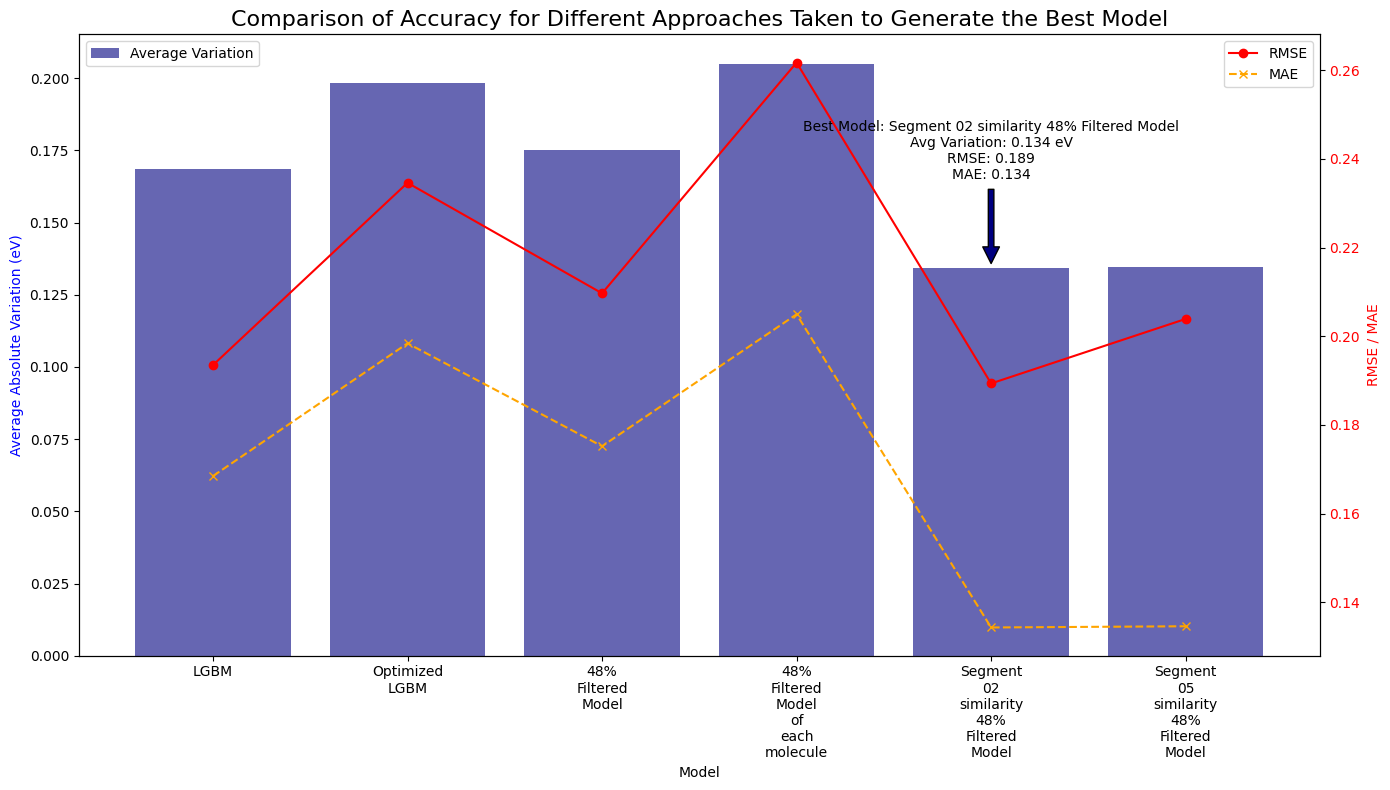

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

data = pd.read_excel(r"C:\Users\Chamod Peiris\OneDrive - Chulalongkorn University\MS_Projects\Cheminformatics\Curcumin_EnergyGap\Curcumin_Masked_Data_Training_FInal.xlsx")

# Calculate absolute variations
data['Abs Variation - LGBM'] = abs(data['Original Energy Gap (eV)'] - data['E Gap - LGBM'])
data['Abs Variation - Optimized LGBM'] = abs(data['Original Energy Gap (eV)'] - data['E Gap - Optimized LGBM'])
data['Abs Variation - 48% Filtered Model'] = abs(data['Original Energy Gap (eV)'] - data['E Gap - 48% Filtered Model'])
data['Abs Variation - 48% Filtered Model of each molecule'] = abs(data['Original Energy Gap (eV)'] - data['E Gap - 48% Filtered Model of each molecule'])
data['Abs Variation - Segment 02 similarity 48% Filtered Model'] = abs(data['Original Energy Gap (eV)'] - data['E Gap - Segment 02 similarity 48% Filtered Model'])
data['Abs Variation - Segment 05 similarity 48% Filtered Model'] = abs(data['Original Energy Gap (eV)'] - data['E Gap - Segment 05 similarity 48% Filtered Model'])

avg_variations = {
    'LGBM': data['Abs Variation - LGBM'].mean(),
    'Optimized LGBM': data['Abs Variation - Optimized LGBM'].mean(),
    '48% Filtered Model': data['Abs Variation - 48% Filtered Model'].mean(),
    '48% Filtered Model of each molecule': data['Abs Variation - 48% Filtered Model of each molecule'].mean(),
    'Segment 02 similarity 48% Filtered Model': data['Abs Variation - Segment 02 similarity 48% Filtered Model'].mean(),
    'Segment 05 similarity 48% Filtered Model': data['Abs Variation - Segment 05 similarity 48% Filtered Model'].mean()
}

# Compute metrics
metrics = {
    'LGBM': {'RMSE': np.sqrt(mean_squared_error(data['Original Energy Gap (eV)'], data['E Gap - LGBM'])), 
              'MAE': mean_absolute_error(data['Original Energy Gap (eV)'], data['E Gap - LGBM'])},
    'Optimized LGBM': {'RMSE': np.sqrt(mean_squared_error(data['Original Energy Gap (eV)'], data['E Gap - Optimized LGBM'])), 
                       'MAE': mean_absolute_error(data['Original Energy Gap (eV)'], data['E Gap - Optimized LGBM'])},
    '48% Filtered Model': {'RMSE': np.sqrt(mean_squared_error(data['Original Energy Gap (eV)'], data['E Gap - 48% Filtered Model'])), 
                           'MAE': mean_absolute_error(data['Original Energy Gap (eV)'], data['E Gap - 48% Filtered Model'])},
    '48% Filtered Model of each molecule': {'RMSE': np.sqrt(mean_squared_error(data['Original Energy Gap (eV)'], data['E Gap - 48% Filtered Model of each molecule'])), 
                                            'MAE': mean_absolute_error(data['Original Energy Gap (eV)'], data['E Gap - 48% Filtered Model of each molecule'])},
    'Segment 02 similarity 48% Filtered Model': {'RMSE': np.sqrt(mean_squared_error(data['Original Energy Gap (eV)'], data['E Gap - Segment 02 similarity 48% Filtered Model'])), 
                                                 'MAE': mean_absolute_error(data['Original Energy Gap (eV)'], data['E Gap - Segment 02 similarity 48% Filtered Model'])},
    'Segment 05 similarity 48% Filtered Model': {'RMSE': np.sqrt(mean_squared_error(data['Original Energy Gap (eV)'], data['E Gap - Segment 05 similarity 48% Filtered Model'])), 
                                                 'MAE': mean_absolute_error(data['Original Energy Gap (eV)'], data['E Gap - Segment 05 similarity 48% Filtered Model'])}
}

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot average variations
model_names = list(avg_variations.keys())
avg_values = list(avg_variations.values())
ax1.bar(model_names, avg_values, color='navy', alpha=0.6, label='Average Variation')
ax1.set_xlabel('Model')
ax1.set_ylabel('Average Absolute Variation (eV)', color='b')
ax1.tick_params(axis='y', labelcolor='black')

# Manually set x-axis labels with wrapped text
wrapped_labels = [label.replace(' ', '\n') for label in model_names]
ax1.set_xticklabels(wrapped_labels, rotation=0, ha='center')  # Ensure text is centered

# Create second y-axis for RMSE and MAE
ax2 = ax1.twinx()
rmse_values = [metrics[model]['RMSE'] for model in model_names]
mae_values = [metrics[model]['MAE'] for model in model_names]

ax2.plot(model_names, rmse_values, color='red', marker='o', linestyle='-', label='RMSE')
ax2.plot(model_names, mae_values, color='orange', marker='x', linestyle='--', label='MAE')
ax2.set_ylabel('RMSE / MAE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add title
plt.title('Comparison of Accuracy for Different Approaches Taken to Generate the Best Model', fontdict={'fontsize': 16})

# Annotate the best model
best_model = min(avg_variations, key=avg_variations.get)  # Find the model with the smallest average variation
best_avg = avg_variations[best_model]
best_rmse = metrics[best_model]['RMSE']
best_mae = metrics[best_model]['MAE']

# Place annotation inside the plot area near the best bar
best_index = model_names.index(best_model)
best_bar_x = best_index
best_bar_height = avg_values[best_index]

ax1.annotate(f'Best Model: {best_model}\nAvg Variation: {best_avg:.3f} eV\nRMSE: {best_rmse:.3f}\nMAE: {best_mae:.3f}',
             xy=(best_bar_x, best_bar_height),
             xytext=(best_bar_x, 0.165),
             arrowprops=dict(facecolor='navy', shrink=0.05),
             ha='center')

fig.tight_layout()
plt.show()

In [ ]:
Dataframes = ["similarity_dfs_seg01_atom_pair_tanimoto",
              "similarity_dfs_seg02_atom_pair_kulczynski", 
              "similarity_dfs_seg03_atom_pair_cosine", 
              "similarity_dfs_seg04_atom_pair_cosine", 
              "similarity_dfs_seg05_atom_pair_cosine",
              "similarity_dfs_seg06_atom_pair_cosine"]

In [120]:
intersect_df_seg01_atom_pair_tanimoto = similarity_dfs_seg01_atom_pair_tanimoto.iloc[:, :3]
intersect_df_seg02_atom_pair_kulczynski = similarity_dfs_seg02_atom_pair_kulczynski.iloc[:, :3]
intersect_df_seg03_atom_pair_cosine = similarity_dfs_seg03_atom_pair_cosine.iloc[:, :3]
intersect_df_seg04_atom_pair_cosine = similarity_dfs_seg04_atom_pair_cosine.iloc[:, :3]
intersect_df_seg05_atom_pair_cosine = similarity_dfs_seg05_atom_pair_cosine.iloc[:, :3]
intersect_df_seg06_atom_pair_cosine = similarity_dfs_seg06_atom_pair_cosine.iloc[:, :3]

intersect_df_seg01_atom_pair_tanimoto.columns

Index(['smiles', 'mol', 'GAP_calib'], dtype='object')

In [125]:
import pandas as pd

# List of dataframes
dataframes = [
    intersect_df_seg01_atom_pair_tanimoto,
    intersect_df_seg02_atom_pair_kulczynski,
    intersect_df_seg03_atom_pair_cosine,
    intersect_df_seg04_atom_pair_cosine,
    intersect_df_seg05_atom_pair_cosine,
    intersect_df_seg06_atom_pair_cosine
]

# Extract SMILES columns from all dataframes
smiles_sets = [set(df['smiles']) for df in dataframes]

# Find common SMILES across all dataframes
common_smiles = set.intersection(*smiles_sets)

# print number of comon smiles
print(f"Number of common SMILES: {len(common_smiles)}")

# Filter rows in each dataframe to only include those with common SMILES
filtered_dfs = [df[df['smiles'].isin(common_smiles)] for df in dataframes]
intersected_df = filtered_dfs[0]
intersected_df

Number of common SMILES: 19186


,smiles,mol,GAP_calib
3,CN1C(=O)C(=Cc2c(F)cc(-c3sc4ccc(C#N)cc4c3C=Cc3c...,<rdkit.Chem.rdchem.Mol object at 0x00000251D26...,2.408787
4,CN1C(=O)C(=Cc2nccc(C=Cc3c(-c4cc(F)cc5nsnc45)sc...,<rdkit.Chem.rdchem.Mol object at 0x00000251D26...,2.940901
5,CN1C(=O)C(=Cc2nc3ccc(-c4cnc(-c5occc5C(=O)c5ccc...,<rdkit.Chem.rdchem.Mol object at 0x00000251D26...,2.422953
6,CN1C(=O)C(=Cc2ccc(C(=O)c3ccoc3-c3ncc(-c4ccc5nc...,<rdkit.Chem.rdchem.Mol object at 0x00000251D26...,2.639241
9,CN1C(=O)C(=Cc2ccnc(-c3ccnc(-c4cscc4C(=O)O)n3)n...,<rdkit.Chem.rdchem.Mol object at 0x00000251D26...,3.283054
...,...,...,...
24633,CN1C(=O)C(=Cc2sc(-c3nccc(-c4cocc4C(=O)c4cccs4)...,<rdkit.Chem.rdchem.Mol object at 0x00000251D23...,2.369179
24635,CN1C(=O)C(=Cc2c(F)cc(-c3c(-c4ccncn4)sc4ccc(C#N...,<rdkit.Chem.rdchem.Mol object at 0x00000251D23...,2.948283
24636,CN1C(=O)C(=Cc2nccc(-c3sc4ccc(C#N)cc4c3-c3cc(F)...,<rdkit.Chem.rdchem.Mol object at 0x00000251D23...,3.496328
24637,CN1C(=O)C(=Cc2ccc3nc(-c4sc5ccc(C#N)cc5c4-c4ccc...,<rdkit.Chem.rdchem.Mol object at 0x00000251D23...,2.856302


In [127]:
intersected_df['Morgan Fingerprints'] = intersected_df['smiles'].apply(generate_morgan_fingerprint_safe)
intersected_df = intersected_df[intersected_df['Morgan Fingerprints'].notnull()].reset_index(drop=True)

morgan_com_df = pd.DataFrame(intersected_df['Morgan Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])
intersected_df = pd.concat([intersected_df, morgan_com_df], axis=1)
intersected_df = intersected_df.drop(columns=['Morgan Fingerprints'])

intersected_df

C:\Users\Chamod Peiris\AppData\Local\Temp\ipykernel_15892\4080543613.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,smiles,mol,GAP_calib,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,morgan_5,morgan_6,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,CN1C(=O)C(=Cc2c(F)cc(-c3sc4ccc(C#N)cc4c3C=Cc3c...,<rdkit.Chem.rdchem.Mol object at 0x00000251D26...,2.408787,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CN1C(=O)C(=Cc2nccc(C=Cc3c(-c4cc(F)cc5nsnc45)sc...,<rdkit.Chem.rdchem.Mol object at 0x00000251D26...,2.940901,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CN1C(=O)C(=Cc2nc3ccc(-c4cnc(-c5occc5C(=O)c5ccc...,<rdkit.Chem.rdchem.Mol object at 0x00000251D26...,2.422953,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CN1C(=O)C(=Cc2ccc(C(=O)c3ccoc3-c3ncc(-c4ccc5nc...,<rdkit.Chem.rdchem.Mol object at 0x00000251D26...,2.639241,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CN1C(=O)C(=Cc2ccnc(-c3ccnc(-c4cscc4C(=O)O)n3)n...,<rdkit.Chem.rdchem.Mol object at 0x00000251D26...,3.283054,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19181,CN1C(=O)C(=Cc2sc(-c3nccc(-c4cocc4C(=O)c4cccs4)...,<rdkit.Chem.rdchem.Mol object at 0x00000251D23...,2.369179,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19182,CN1C(=O)C(=Cc2c(F)cc(-c3c(-c4ccncn4)sc4ccc(C#N...,<rdkit.Chem.rdchem.Mol object at 0x00000251D23...,2.948283,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19183,CN1C(=O)C(=Cc2nccc(-c3sc4ccc(C#N)cc4c3-c3cc(F)...,<rdkit.Chem.rdchem.Mol object at 0x00000251D23...,3.496328,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19184,CN1C(=O)C(=Cc2ccc3nc(-c4sc5ccc(C#N)cc5c4-c4ccc...,<rdkit.Chem.rdchem.Mol object at 0x00000251D23...,2.856302,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
curcumin_df_mf

,Molecule,Molecular Weight,LogP,Homo-Lumo Gap (eV),Smiles,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,2-ADMeO3,532.345,5.02930,3.077,COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3-MR83a,472.293,5.01210,3.072,COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AD-10,472.293,5.01210,3.259,COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+]...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AD-1013,482.335,7.29270,2.625,COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1cc...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AD-1022,472.293,5.01210,2.938,COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,AD-11,444.239,4.40610,2.946,COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+]...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,AD-14-Moore,438.327,5.10970,2.811,CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,AD-16-DMF,377.199,4.84938,3.231,N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,AD-18,506.357,7.88370,2.735,COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,AD-24,512.361,7.30130,2.878,COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 14389, number of used features: 1142
[LightGBM] [Info] Start training from score 2.634151


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



MAE Value: 0.09264 & RMSE Value: 0.13407
Prediction --> model MAE: 0.12047 & RMSE: 0.02570


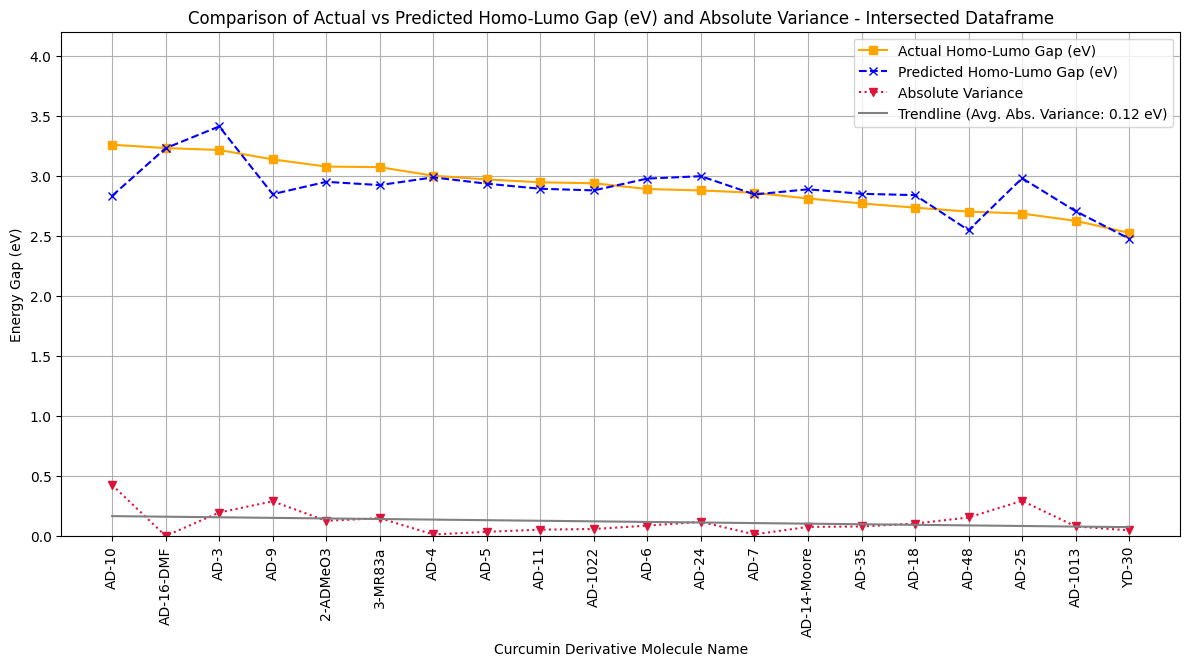

In [133]:
X = intersected_df.iloc[:, 3:]
y = intersected_df['GAP_calib']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Initialize and train the LightGBM model
tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
model = lgb.LGBMRegressor(**tuned_params)
model.fit(X_train, y_train)

# Make predictions and calculate R^2 score
y_pred = model.predict(X_test)

# Calculate MAE Value and RMSE for the model
mae_model = mean_absolute_error(y_test, y_pred)
rmse_model = mean_squared_error(y_test, y_pred, squared=False)

curcumin_df_mf_pred = curcumin_df_mf.copy()
curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 5:])

mae_predict = mean_absolute_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])

print(f"MAE Value: {mae_model:.5f} & RMSE Value: {rmse_model:.5f}")
print(f"Prediction --> model MAE: {mae_predict:.5f} & RMSE: {rmse_predict:.5f}")

# Sort curcumin_df_mf_pred by 'Homo-Lumo Gap (eV)' in descending order and reset the index
curcumin_df_mf_pred = curcumin_df_mf_pred.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)

# Calculate the absolute variance between 'Homo-Lumo Gap (eV)' and 'Homo-Lumo Gap (eV) Pred'
curcumin_df_mf_pred['absolute_variance'] = (curcumin_df_mf_pred['Homo-Lumo Gap (eV)'] - curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred']).abs()

# Save DF
curcumin_df_mf_pred.to_csv(path_or_buf=(f"C:/Users/Chamod Peiris/Documents/Curcumin_Scripts/curcumin_pred_Intersected.csv"))

# Calculate linear trendline for absolute variance
x_vals = curcumin_df_mf_pred.index
y_vals = curcumin_df_mf_pred['absolute_variance']
coefficients = np.polyfit(x_vals, y_vals, 1)  # Fit a linear polynomial
trendline = np.polyval(coefficients, x_vals)

# Calculate the average absolute variance
average_variance = y_vals.mean()

# Plotting the actual vs predicted energy gaps
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the actual values
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='s', label='Actual Homo-Lumo Gap (eV)', color='orange')

# Plot the predicted values
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'], marker='x', linestyle='--', label='Predicted Homo-Lumo Gap (eV)', color='blue')

# Plot the absolute variance as a dotted line
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['absolute_variance'], marker='v', linestyle=':', label='Absolute Variance', color='crimson')

# Plot the trendline for absolute variance
ax1.plot(curcumin_df_mf_pred['Molecule'], trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')

# Set labels for the axes and the range
ax1.set_xlabel('Curcumin Derivative Molecule Name')
ax1.set_ylabel('Energy Gap (eV)')
ax1.set_ylim([0, 4.2])  # Adjust the y-axis range as needed
ax1.tick_params(axis='y')
ax1.legend(loc='upper right')

# Customize the plot
plt.title('Comparison of Actual vs Predicted Homo-Lumo Gap (eV) and Absolute Variance - Intersected Dataframe')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

data = pd.read_excel(r"C:\Users\Chamod Peiris\OneDrive - Chulalongkorn University\MS_Projects\Cheminformatics\Curcumin_EnergyGap\Curcumin_Masked_Data_Training_FInal.xlsx")
data.columns

Index(['Molecule', 'Molecular Weight', 'LogP', 'Original Energy Gap (eV)',
       'Smiles', 'E Gap - LGBM', 'E Gap - Optimized LGBM',
       'E Gap - 48% Filtered Model',
       'E Gap - 48% Filtered Model of each molecule',
       'E Gap - Segment 02 similarity 48% Filtered Model',
       'E Gap - Segment 05 similarity 48% Filtered Model',
       'E Gap - Intersected Model'],
      dtype='object')

C:\Users\Chamod Peiris\AppData\Local\Temp\ipykernel_15892\107900745.py:51: UserWarning:

FixedFormatter should only be used together with FixedLocator



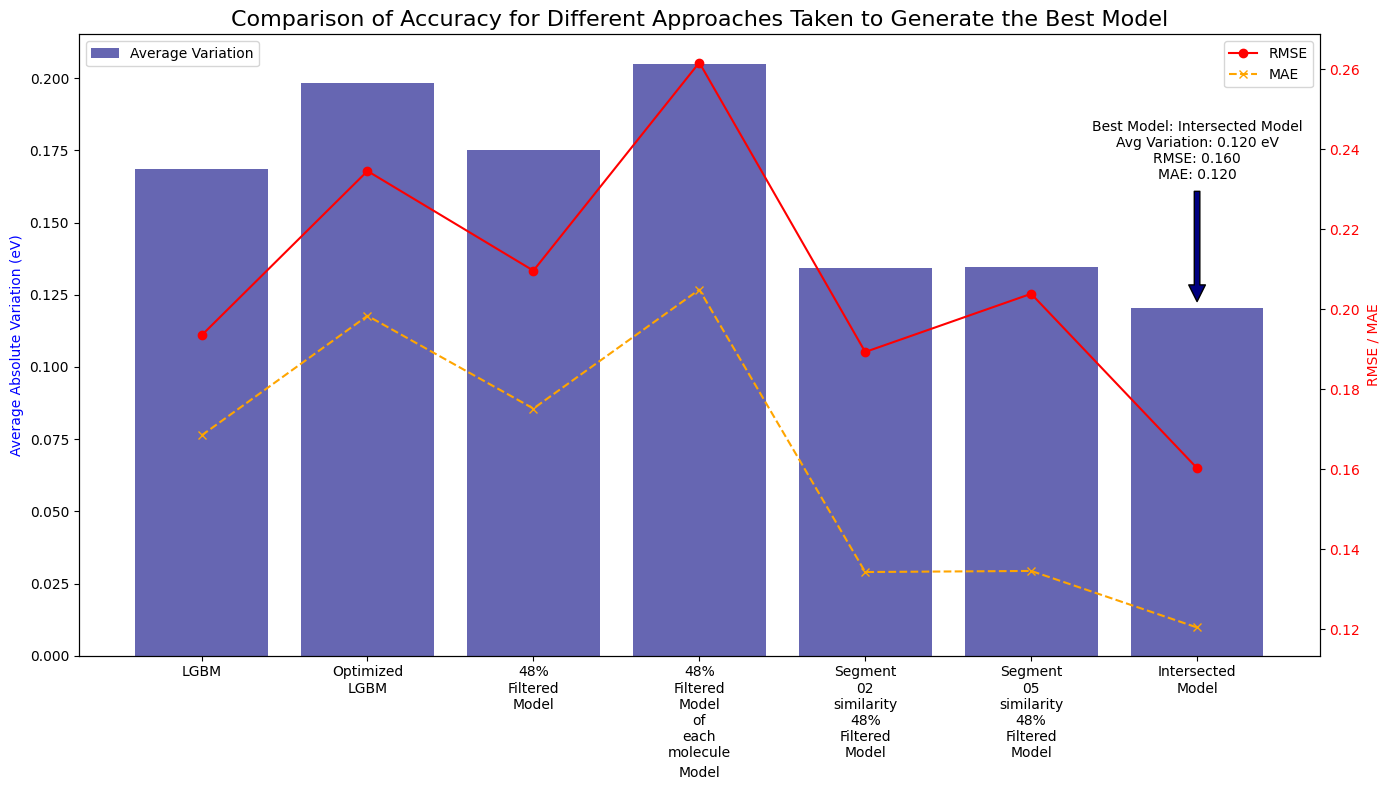

In [136]:
# Calculate absolute variations
data['Abs Variation - LGBM'] = abs(data['Original Energy Gap (eV)'] - data['E Gap - LGBM'])
data['Abs Variation - Optimized LGBM'] = abs(data['Original Energy Gap (eV)'] - data['E Gap - Optimized LGBM'])
data['Abs Variation - 48% Filtered Model'] = abs(data['Original Energy Gap (eV)'] - data['E Gap - 48% Filtered Model'])
data['Abs Variation - 48% Filtered Model of each molecule'] = abs(data['Original Energy Gap (eV)'] - data['E Gap - 48% Filtered Model of each molecule'])
data['Abs Variation - Segment 02 similarity 48% Filtered Model'] = abs(data['Original Energy Gap (eV)'] - data['E Gap - Segment 02 similarity 48% Filtered Model'])
data['Abs Variation - Segment 05 similarity 48% Filtered Model'] = abs(data['Original Energy Gap (eV)'] - data['E Gap - Segment 05 similarity 48% Filtered Model'])
data['Abs Variation - Intersected Model'] = abs(data['Original Energy Gap (eV)'] - data['E Gap - Intersected Model'])

avg_variations = {
    'LGBM': data['Abs Variation - LGBM'].mean(),
    'Optimized LGBM': data['Abs Variation - Optimized LGBM'].mean(),
    '48% Filtered Model': data['Abs Variation - 48% Filtered Model'].mean(),
    '48% Filtered Model of each molecule': data['Abs Variation - 48% Filtered Model of each molecule'].mean(),
    'Segment 02 similarity 48% Filtered Model': data['Abs Variation - Segment 02 similarity 48% Filtered Model'].mean(),
    'Segment 05 similarity 48% Filtered Model': data['Abs Variation - Segment 05 similarity 48% Filtered Model'].mean(),
    'Intersected Model': data['Abs Variation - Intersected Model'].mean()
}

# Compute metrics
metrics = {
    'LGBM': {'RMSE': np.sqrt(mean_squared_error(data['Original Energy Gap (eV)'], data['E Gap - LGBM'])), 
              'MAE': mean_absolute_error(data['Original Energy Gap (eV)'], data['E Gap - LGBM'])},
    'Optimized LGBM': {'RMSE': np.sqrt(mean_squared_error(data['Original Energy Gap (eV)'], data['E Gap - Optimized LGBM'])), 
                       'MAE': mean_absolute_error(data['Original Energy Gap (eV)'], data['E Gap - Optimized LGBM'])},
    '48% Filtered Model': {'RMSE': np.sqrt(mean_squared_error(data['Original Energy Gap (eV)'], data['E Gap - 48% Filtered Model'])), 
                           'MAE': mean_absolute_error(data['Original Energy Gap (eV)'], data['E Gap - 48% Filtered Model'])},
    '48% Filtered Model of each molecule': {'RMSE': np.sqrt(mean_squared_error(data['Original Energy Gap (eV)'], data['E Gap - 48% Filtered Model of each molecule'])), 
                                            'MAE': mean_absolute_error(data['Original Energy Gap (eV)'], data['E Gap - 48% Filtered Model of each molecule'])},
    'Segment 02 similarity 48% Filtered Model': {'RMSE': np.sqrt(mean_squared_error(data['Original Energy Gap (eV)'], data['E Gap - Segment 02 similarity 48% Filtered Model'])), 
                                                 'MAE': mean_absolute_error(data['Original Energy Gap (eV)'], data['E Gap - Segment 02 similarity 48% Filtered Model'])},
    'Segment 05 similarity 48% Filtered Model': {'RMSE': np.sqrt(mean_squared_error(data['Original Energy Gap (eV)'], data['E Gap - Segment 05 similarity 48% Filtered Model'])), 
                                                 'MAE': mean_absolute_error(data['Original Energy Gap (eV)'], data['E Gap - Segment 05 similarity 48% Filtered Model'])},
    'Intersected Model': {'RMSE': np.sqrt(mean_squared_error(data['Original Energy Gap (eV)'], data['E Gap - Intersected Model'])),
                                'MAE': mean_absolute_error(data['Original Energy Gap (eV)'], data['E Gap - Intersected Model'])}
}

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot average variations
model_names = list(avg_variations.keys())
avg_values = list(avg_variations.values())
ax1.bar(model_names, avg_values, color='navy', alpha=0.6, label='Average Variation')
ax1.set_xlabel('Model')
ax1.set_ylabel('Average Absolute Variation (eV)', color='b')
ax1.tick_params(axis='y', labelcolor='black')

# Manually set x-axis labels with wrapped text
wrapped_labels = [label.replace(' ', '\n') for label in model_names]
ax1.set_xticklabels(wrapped_labels, rotation=0, ha='center')  # Ensure text is centered

# Create second y-axis for RMSE and MAE
ax2 = ax1.twinx()
rmse_values = [metrics[model]['RMSE'] for model in model_names]
mae_values = [metrics[model]['MAE'] for model in model_names]

ax2.plot(model_names, rmse_values, color='red', marker='o', linestyle='-', label='RMSE')
ax2.plot(model_names, mae_values, color='orange', marker='x', linestyle='--', label='MAE')
ax2.set_ylabel('RMSE / MAE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add title
plt.title('Comparison of Accuracy for Different Approaches Taken to Generate the Best Model', fontdict={'fontsize': 16})

# Annotate the best model
best_model = min(avg_variations, key=avg_variations.get)  # Find the model with the smallest average variation
best_avg = avg_variations[best_model]
best_rmse = metrics[best_model]['RMSE']
best_mae = metrics[best_model]['MAE']

# Place annotation inside the plot area near the best bar
best_index = model_names.index(best_model)
best_bar_x = best_index
best_bar_height = avg_values[best_index]

ax1.annotate(f'Best Model: {best_model}\nAvg Variation: {best_avg:.3f} eV\nRMSE: {best_rmse:.3f}\nMAE: {best_mae:.3f}',
             xy=(best_bar_x, best_bar_height),
             xytext=(best_bar_x, 0.165),
             arrowprops=dict(facecolor='navy', shrink=0.05),
             ha='center')

fig.tight_layout()
plt.show()